In [1]:
#%cd ~/work/charlie/etdm_water_octonol/pmf_setup/bigger_box4/
#!pwd
import pymbar
from pymbar import timeseries
!python3 --version
import numpy as np
import numpy
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import axes
import seaborn as sns
import csv
import os as os
import sys

import ipywidgets as widgets
from ipywidgets import interact,interact_manual

import tqdm
import gc

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [2]:
#kB = 1.381e-23 * 6.022e23 / 1000.0 # Boltzmann constant in kJ/mol/K
kB=0.001985875 #kcal/(mol*K)
temperature = 300 # assume a single temperature -- can be overridden with data from center.dat 
# Parameters
K = 28 # number of umbrellas +1
S = 2 # number of steps +1
N_max = 100001 # maximum number of snapshots/simulation
T_k = numpy.ones(K,float)*temperature # inital temperatures are all equal 
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kJ/mol))
chi_min = -28 # min for PMF
chi_max = 28 # max for PMF
nbins = 28 # number of bins for 1D PMF

In [18]:
# #for creating metadatafile

# #%cd ~/work/charlie/etdm_water_octonol/pmf_setup/bigger_box4/
# fileName=[]
# centers=[]
# k=[]

# for s in np.arange(S):
#     if s == 1:
#         for k in np.arange(K):
#             if k > 0:
#                 name=('US/window_{:0>2d}_rest.step_8.dat.z'.format(k))
#                 fileName.append(name)
#                 centersRange=np.arange(0,29,2)
#                 centers.append(centersRange[k])
#                 k=[2.5*2]*len(centers) ## 0.5 is FC
#         for x in fileName:
#             dict={"file":fileName,"centers":centers,"k":k}
#         metadata=pd.DataFrame(data=dict)
#         metadata.to_csv("metadata.dat", index=False, header=None,sep=" ")

In [21]:
fileName=[]
centers=[]
k=[]
for k in np.arange(K):
    #print (k)
    if k >-1:
        name=('window_{:0>2d}_rest.step_all.dat.z'.format(k))
        fileName.append(name)
        centersRange=np.arange(-27,29,2)
        centers.append(centersRange[k])
        k=[2.5]*len(centers)
        for x in fileName:
            dict={"file":fileName,"centers":centers,"k":k}
        metadata=pd.DataFrame(data=dict)
        metadata.to_csv("metadata.dat", index=False, header=None,sep=" ")

In [22]:
# Allocate storage for simulation data
N_k = numpy.zeros([K], numpy.int32) # N_k[k] is the number of snapshots from umbrella simulation k
K_k = numpy.zeros([K], numpy.float64) # K_k[k] is the spring constant (in kJ/mol/deg**2) for umbrella simulation k
chi0_k = numpy.zeros([K], numpy.float64) # chi0_k[k] is the spring center location (in deg) for umbrella simulation k
chi_kn = numpy.zeros([K,N_max], numpy.float64) # chi_kn[k,n] is the torsion angle (in deg) for snapshot n from umbrella simulation k
u_kn = numpy.zeros([K,N_max], numpy.float64) # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
g_k = numpy.zeros([K],numpy.float32);


In [25]:
## for WHAM ## 
# for s in np.arange(S):
#     if s>1:
#         print(pd.read_csv('metadata-{}.dat'.format(s),delim_whitespace=True, header=None))

# %cd ~/charlie/wham/wham

# !./wham 85.0 196.0 224 0.0000000001 310.15 0 ~/charlie/etdm_water_octonol/pmf_setup/bigger_box4/metadata-2.dat ~/charlie/etdm_water_octonol/pmf_setup/bigger_box4/wham_85_196_224-2
# min max bin_size 0.0000000001 temp

# %cd ~/work/charlie/etdm_water_octonol/pmf_setup/bigger_box4/

# remove "#" signs before readin
# !sed '/#/d' wham_85_196_224-2 > wham_85_196_224-2.pmf

#whampmf2=pd.read_csv("wham.pmf",delim_whitespace=True,header=None)

# wham_coord_arr=[whampmf2[0],whampmf3[0],whampmf4[0],whampmf5[0],whampmf6[0],whampmf7[0],whampmf8[0],whampmf9[0],whampmf10[0],whampmf11[0],whampmf12[0],whampmf13[0],whampmf14[0]]



In [4]:
whampmf2=pd.read_csv("wham.pmf",delim_whitespace=True,header=None)
whampmf2.columns=['Z_window','PMF_energy','Uncertainty','x','NONE']
print (whampmf2.head())

   Z_window  PMF_energy  Uncertainty         x  NONE
0   -27.965    0.797506          NaN  0.001021   NaN
1   -27.895    0.647296          NaN  0.001314   NaN
2   -27.825    0.643805          NaN  0.001321   NaN
3   -27.755    0.659841          NaN  0.001286   NaN
4   -27.685    0.713889          NaN  0.001175   NaN


In [4]:
print (whampmf2.tail())

     Z_window  PMF_energy  Uncertainty         x  NONE
795    27.685    0.838250          NaN  0.003789   NaN
796    27.755    0.694709          NaN  0.004823   NaN
797    27.825    0.708089          NaN  0.004716   NaN
798    27.895    0.601741          NaN  0.005639   NaN
799    27.965    0.315914          NaN  0.009118   NaN


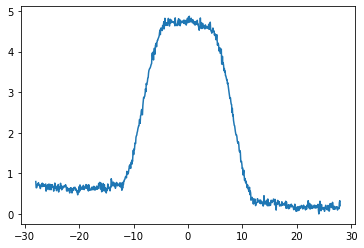

In [5]:
plt.plot(whampmf2.Z_window,whampmf2.PMF_energy)

In [19]:
# filename = ('window_{}.{}_rest.step_8.dat.z'.format(k,s))
# #print ("Reading %s..." % filename)
# print (filename)
# for k in range(K):
#     #print (k)
#     filename=('window_{}_rest.step_8.dat.z'.format(k))
#     print (filename)

In [24]:
infile = open('US_win_center.txt', 'r')
lines = infile.readlines()
infile.close()
for k in range(K):
    # Parse line k.
    line = lines[k]
    tokens = line.split(",")
    chi0_k[k] = float(tokens[0]) # spring center location 
    K_k[k] = float(tokens[1]) # spring constant 
    if len(tokens) > 2:
        T_k[k] = float(tokens[2])  # temperature the kth simulation was run at.
# print(tokens[1])

mbar_dats=[]
mbar_dat=pd.DataFrame()

for s in range(S):
    if s > 1:
        beta_k = 1.0/(kB*T_k)   # beta factor for the different temperatures
        DifferentTemperatures = True
        if (min(T_k) == max(T_k)):
            DifferentTemperatures = False            # if all the temperatures are the same, then we don't have to read in energies.
        # Read the simulation data
        for k in range(K):
            # Read torsion angle data.
            #filename = ('step5.{:0>2d}.{}_pmfSetup.dat.z'.format(k,s))
            filename = ('window_{}_rest.step_8.dat.z'.format(k))
            print ("Reading %s..." % filename)
            infile = open(filename, 'r')
            lines = infile.readlines()
            infile.close()
            # Parse data.
            n = 0
            for line in lines:
                if line[0] != 'c':
                    tokens = line.split(" ")
                    try:
                        chi_kn[k,n] = float(tokens[1]) # torsion angle
                    except ValueError:
                        chi_kn[k,n] = 2.5
                    n += 1
            N_k[k] = n


            if (DifferentTemperatures):  # if different temperatures are specified the metadata file, 
                                         # then we need the energies to compute the PMF
                # Read energies
                filename = ('window_{}_rest.step_8.dat.z'.format(k))
                print ("Reading %s..." % filename)
                infile = open(filename, 'r')
                lines = infile.readlines()
                infile.close()
                # Parse data.
                n = 0
                for line in lines:
                    if line[0] != 'N':
                        tokens = line.split(",")            
                        u_kn[k,n] = beta_k[k] * (float(tokens[2]) - float(tokens[1])) # reduced potential energy without umbrella restraint
                        n += 1

            # Compute correlation times for potential energy and chi
            # timeseries.  If the temperatures differ, use energies to determine samples; otherwise, use the cosine of chi
            if (DifferentTemperatures):        
                g_k[k] = timeseries.statisticalInefficiency(u_kn[k,:], u_kn[k,0:N_k[k]])
                print ("Correlation time for set %5d is %10.3f" % (k,g_k[k]))
                indices = timeseries.subsampleCorrelatedData(u_kn[k,0:N_k[k]])
            else:
                print("corr",chi_kn[k,:], chi_kn[k,0:N_k[k]])
                g_k[k] = timeseries.statisticalInefficiency(chi_kn[k,0:N_k[k]])
                print ("Correlation time for set %5d is %10.3f" % (k,g_k[k]))
                indices = timeseries.subsampleCorrelatedData(chi_kn[k,0:N_k[k]], g=g_k[k]) 
            # Subsample data.
            print("number of uncorrelated frames",len(indices))
            N_k[k] = len(indices)
            u_kn[k,0:N_k[k]] = u_kn[k,indices]
            chi_kn[k,0:N_k[k]] = chi_kn[k,indices]

        N_max = numpy.max(N_k) # shorten the array size
        u_kln = numpy.zeros([K,K,N_max], numpy.float64) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l

        # Set zero of u_kn -- this is arbitrary.
        u_kn -= u_kn.min()
        print(u_kn)
        # Construct torsion bins
        print ("Binning data...")
        delta = (chi_max - chi_min) / float(nbins)
        # compute bin centers
        bin_center_i = numpy.zeros([nbins], numpy.float64)
        for i in range(nbins):
            bin_center_i[i] = chi_min + delta/2 + delta * i
        # Bin data
        bin_kn = numpy.zeros([K,N_max], numpy.int32)
        for k in range(K):
            for n in range(N_k[k]):
                # Compute bin assignment.
                bin_kn[k,n] = int((chi_kn[k,n] - chi_min) / delta)
        print("done")
        print ("Evaluating reduced potential energies...")
        for k in range(K):
            for n in range(N_k[k]):
                # Compute minimum-image torsion deviation from umbrella center l
                dchi = chi_kn[k,n] - chi0_k

                # Compute energy of snapshot n from simulation k in umbrella potential l
                u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k/2.0) * dchi**2

        # Initialize MBAR.
        print ("Running MBAR...")
        mbar = pymbar.MBAR(u_kln, N_k, verbose = True, method = 'adaptive')

        # Compute PMF in unbiased potential (in units of kT).
        (f_i, df_i) = mbar.computePMF(u_kn, bin_kn, nbins)

        # Write out PMF
        print ("PMF (in units of kT)")
        print ("%8s %8s %8s" % ('bin', 'f', 'df'))
        for i in range(nbins):
            print ("%8.1f %8.3f %8.3f" % (bin_center_i[i], f_i[i], df_i[i]))
        mbar_dat['bin_center']=bin_center_i
        mbar_dat['f_i']=f_i
        mbar_dat['df_i']=df_i
        mbar_dats.append(mbar_dat.copy())
mbar_data=pd.concat(mbar_dats)
mbar_data.head()

mbar_data.to_csv("mbar_data.csv",index=False)

ValueError: No objects to concatenate

In [96]:
#%cd ~/work/charlie/etdm_water_octonol/pmf_setup/bigger_box4
mbar_data_accum=pd.read_csv('mbar_data.csv')
mbar_data_accum=mbar_data_accum.groupby(['bin_center']).mean()

#mbar_data_accum.to_csv("mbar_data_accum.csv")

In [99]:
print (mbar_data_accum.tail())

            0         1   2         3   4
795  26.69625  1.306226 NaN  0.001861 NaN
796  26.76375  1.359961 NaN  0.001700 NaN
797  26.83125  1.440507 NaN  0.001485 NaN
798  26.89875  1.435851 NaN  0.001497 NaN
799  26.96625  1.399365 NaN  0.001591 NaN


     z_coor       pmf
0   -27.965  1.395032
1   -27.895  1.407571
2   -27.825  1.554580
3   -27.755  1.708866
4   -27.685  1.888914
..      ...       ...
795  27.685  0.838250
796  27.755  0.694709
797  27.825  0.708089
798  27.895  0.601741
799  27.965  0.315914

[800 rows x 2 columns]


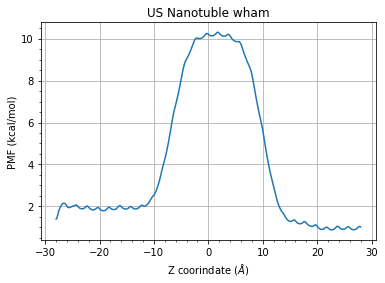

In [7]:
## rolling datapoint for wham ## 
#%cd ~/work/charlie/etdm_water_octonol/pmf_setup/bigger_box4
wham_data_accum=pd.read_csv("wham.pmf",delim_whitespace=True,header=None)


wham_data_accum = {'z_coor':wham_data_accum[0],'pmf':wham_data_accum[1]}

wham_data_accum=pd.DataFrame(wham_data_accum)
print (wham_data_accum)
wham_data_accum['pmf']=wham_data_accum['pmf'].rolling(window=50,min_periods=1).mean()
wham_data_accum.to_csv('wham_pmf.csv',index=False)
plt.plot(wham_data_accum.z_coor, wham_data_accum.pmf)
plt.xlabel('Z coorindate ($\AA$)')
plt.ylabel('PMF (kcal/mol)')
plt.title('US Nanotuble wham')
plt.minorticks_on()
plt.grid()
# all_data=wham_data_accum.join(mbar_data_accum)

# all_data.to_csv("eth_wham_mbar.csv",index=False)

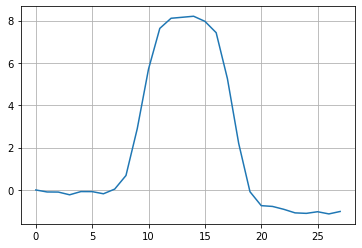

In [39]:
t_wham=pd.read_csv('../t.pmf.csv',delim_whitespace=True, header=None)
t_wham.columns=['bin_center','pmf']
tt.head()
#t_wham=t_wham.groupby(['bin_center']).mean()
#t_wham['bin_center']=np.arange(-27,29,2)
#t_wham
plt.plot(t_wham.pmf)
plt.grid()

In [4]:
mbar_data_accum.head()

,mbarx,f_i,df_i
0,85.991071,0.958316,0.437591
1,87.973214,1.558388,0.445272
2,89.955357,1.588983,0.444714
3,91.937500,1.545733,0.443325
4,93.919643,1.559654,0.441466
